# Importing libraries and Loading data

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from timm import create_model
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.models import vgg16, vgg19
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'Total number of images in CIFAR 10 test_loader: {len(test_dataset)}')

cifar10_classes = [
    'airplane', 'automobile',  'ship', 'truck'
    'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
]

100%|██████████| 170498071/170498071 [00:03<00:00, 48620775.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 10000


# Helper functions and visualizing utils

torch.Size([3, 32, 32])


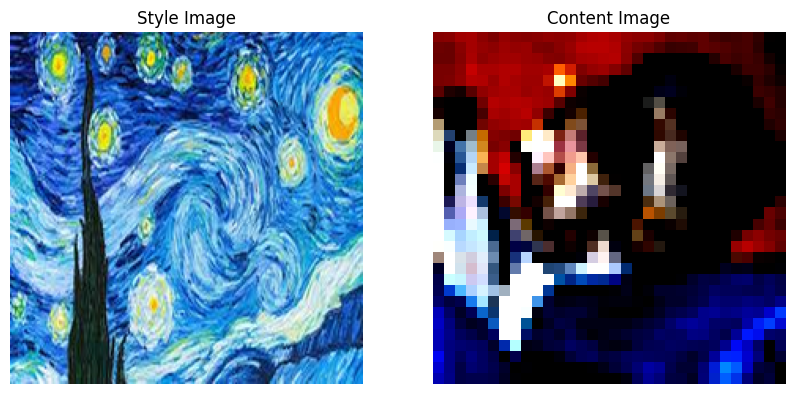

In [ ]:
def load_image(image_input):
    if not isinstance(image_input, torch.Tensor):
        image = Image.open(image_input)
        image = image.resize((224, 224), Image.LANCZOS)
        image_array = np.array(image)
    else:  #tensors from dataset are already resized
      image = image_input
      if image_input.dim() == 4:  #extra batch dimension
        image_array = image_input.squeeze(0).cpu().numpy()
      else:
        image_array = image_input.cpu().numpy()


    if isinstance(image_input, torch.Tensor):  #transpose the tensor from dataset from viewing in plot if required
      image_array = np.transpose(image_array,(1, 2, 0))  # Convert CHW to HWC

    return image_array

# Load and preprocess the content and style images
style_pic_path = 'starry_night.jpg'
img, _ = test_dataset[0]
print(img.shape)
content_img = load_image(img)
style_img = load_image(style_pic_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')
plt.show()

In [ ]:
#function to extract features from the VGG mdoel
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content layer
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# function to calculate the Gram matrix:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# function to visualise images with diff styles
def show_images_diff_styles(style_img, content_img, styled_content_img):

  if isinstance(content_img, torch.Tensor):
    content_img = content_img.cpu().numpy()
    content_img = np.transpose(content_img,(1, 2, 0))

  styled_img = load_image(styled_content_img)

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(style_img)
  plt.title('Style Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(content_img)
  plt.title('Content Image')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(styled_img)
  plt.title('Styled Content Image')
  plt.axis('off')
  plt.show()

def savedata(img_tensor, img_label,i):
  print("Saving ",f'/content/generated_dataset/images/img_{i:04d}.pt', img_label)
  torch.save(img_tensor, f'/content/generated_dataset/images/img_{i:04d}.pt')  # Save tensor
  with open(f'/content/generated_dataset/labels.txt', 'a') as f:
    f.write(f'img_{i:04d}.pt {img_label}\n')  # Save label

In [ ]:
# del vgg19
# torch.cuda.empty_cache()
vgg19 = vgg19(pretrained=True).features
vgg19 = vgg19.to(device)
vgg19.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.9MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Creating folders
directory_name = 'generated_dataset/images'  # Change this to your desired folder name
full_path = os.path.join('/content', directory_name)
os.makedirs(full_path, exist_ok=True)
file_path = '/content/generated_dataset/labels.txt'
with open(file_path, 'w') as f:
    pass
print(f"Empty file created at: {file_path}")

Empty file created at: /content/generated_dataset/labels.txt


In [ ]:
# # # Delete all files inside the folder

# folder_path = '/content/shortened_dataset/images'
# if os.path.exists(folder_path):
#     for filename in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, filename)
#         try:
#             if os.path.isfile(file_path):  # Check if it is a file
#                 os.remove(file_path)      # Delete the file
#         except Exception as e:
#             print(f"Error deleting file {file_path}: {e}")

In [ ]:
# Viewing a tensor
# tensor_path = '/content/generated_dataset/images/img_0002.pt'  # Adjust this to your desired image tensor
# img_tensor = torch.load(tensor_path)
# img  = load_image(img_tensor)
# plt.imshow(img)
# plt.axis('off')  # Remove axis lines and labels
# plt.show()

# tensor_path = '/content/shortened_dataset/images/img_0002.pt'  # Adjust this to your desired image tensor
# img_tensor = torch.load(tensor_path)
# img  = load_image(img_tensor)
# plt.imshow(img)
# plt.axis('off')  # Remove axis lines and labels
# plt.show()

# Creating short datatset and saving it to zip file

In [ ]:
#Creating shortened dataset (of 1000 images) from test dataset (of 10000 images) w/ stratification

from torch.utils.data import Subset
from collections import defaultdict

class_indices = defaultdict(list)
for idx, (image, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

np.random.seed(42)  # For reproducibility
shortened_indices = []

for class_label, indices in class_indices.items():
    selected_indices = np.random.choice(indices, 100, replace=False)
    shortened_indices.extend(selected_indices)

shortened_dataset = Subset(test_dataset, shortened_indices)
shortened_loader = DataLoader(shortened_dataset, batch_size=32, shuffle=True)
print(f'Total samples in the shortened dataset: {len(shortened_dataset)}')

# To verify class distribution
class_count = defaultdict(int)
for _, label in shortened_dataset:
    class_count[label] += 1
for class_label, count in class_count.items():
    print(f'Class {class_label}: {count} samples')  #100 samples per class

Total samples in the shortened dataset: 1000
Class 3: 100 samples
Class 8: 100 samples
Class 0: 100 samples
Class 6: 100 samples
Class 1: 100 samples
Class 9: 100 samples
Class 5: 100 samples
Class 7: 100 samples
Class 4: 100 samples
Class 2: 100 samples


In [ ]:
import os
import torch
import zipfile

# # Step 1: Create a directory to store the image tensors and labels
output_dir = '/content/shortened_dataset'
images_dir = os.path.join(output_dir, 'images')
labels_file = os.path.join(output_dir, 'labels.txt')

os.makedirs(images_dir, exist_ok=True)

# Step 2: Loop through the shortened_loader and save the tensors and labels
for batch_idx, (images, labels) in enumerate(shortened_loader):
    for i in range(images.size(0)):
        img_tensor = images[i]  # Tensor for each image
        label = labels[i].item()  # Class label for each image

        # Save tensor to .pt file
        torch.save(img_tensor, f"{images_dir}/img_{(batch_idx * shortened_loader.batch_size) + i:04d}.pt")

        # Append label to labels.txt
        with open(labels_file, 'a') as f:
            f.write(f"img_{(batch_idx * shortened_loader.batch_size) + i:04d}.pt {label}\n")

  adding: content/shortened_dataset/ (stored 0%)
  adding: content/shortened_dataset/images/ (stored 0%)
  adding: content/shortened_dataset/images/img_0719.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0203.pt (deflated 64%)
  adding: content/shortened_dataset/images/img_0901.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0724.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0042.pt (deflated 64%)
  adding: content/shortened_dataset/images/img_0539.pt (deflated 64%)
  adding: content/shortened_dataset/images/img_0116.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0026.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0815.pt (deflated 66%)
  adding: content/shortened_dataset/images/img_0763.pt (deflated 64%)
  adding: content/shortened_dataset/images/img_0913.pt (deflated 65%)
  adding: content/shortened_dataset/images/img_0873.pt (deflated 64%)
  adding: content/shortened_dataset/images/img_0572.pt 

In [ ]:
# Step 3: Zip the folder containing the image tensors and labels
!zip -r /content/shortened_dataset/images.zip /content/shortened_dataset

In [ ]:
# zip_filename = '/content/shortened_dataset.zip'
# unzip_dir = '/content/shortened_dataset_unzipped'
# with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
#     zip_ref.extractall(unzip_dir)

# Define paths for images and labels
unzip_dir = '/content/shortened_dataset'
images_dir = os.path.join(unzip_dir, 'images')
labels_file = os.path.join(unzip_dir, 'labels.txt')

# Step 2: Load the image tensors and labels
def load_images_and_labels(images_dir, labels_file):
    image_tensors = []
    labels = []
    imgnames = []

    with open(labels_file, 'r') as f:
        for line in f:
            img_name, label = line.strip().split()  # Splitting the line to extract the label
            labels.append(int(label))
            imgnames.append(img_name)

    for i in range(len(labels)):
        img_tensor = torch.load(os.path.join(images_dir, imgnames[i]))
        image_tensors.append(img_tensor)

    return image_tensors, labels

# Load the image tensors and labels
shortened_imgs, shortened_labels = load_images_and_labels(images_dir, labels_file)
print(len(shortened_imgs), len(shortened_labels))

<ipython-input-13-40bc7f43a48b>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_tensor = torch.load(os.path.join(images_dir, imgnames[i]))


1000 1000


# Running short dataset for style transfer

In [ ]:
def style_transfer(content_img, style_img, num_steps=85, style_weight=0.2, content_weight=0.8):

    if not isinstance(content_img, torch.Tensor):
        content_img = torch.from_numpy(content_img).float().permute(2, 0, 1).unsqueeze(0)
    if not isinstance(style_img, torch.Tensor):
        style_img = torch.from_numpy(style_img).float().permute(2, 0, 1).unsqueeze(0)
        style_img /=255

    target = content_img.to(device).clone().detach().requires_grad_(True)
    content_img = content_img.to(device)
    style_img = style_img.to(device)

    # def checknorm(img):  #check if images have been normalized or not
    #   min_value = img.min().item()
    #   max_value = img.max().item()
    #   print(min_value,max_value)

    # checknorm(style_img)
    # checknorm(target)

    optimizer = torch.optim.Adam([target], lr=0.2)
    content_features = get_features(content_img, vgg19)
    style_features = get_features(style_img, vgg19)

    style_weights = {'conv1_1': 1.0,
                     'conv2_1': 0.8,
                     'conv3_1': 0.5,
                     'conv4_1': 0.3,
                     'conv5_1': 0.1}

    for i in range(1, num_steps+1):
        target_features = get_features(target, vgg19)

        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = gram_matrix(style_features[layer])
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()

        # if i % 50 == 0:
        #     print(f'Step {i}/{num_steps}: Total Loss: {total_loss.item()}')

    return target.detach()

# Apply style transfer to CIFAR-10 images
# def apply_style_transfer(data_loader, style_image):
#     styled_images = []
#     labels_list = []
#     for j,(images, labels) in enumerate(data_loader):
#         # print(labels)
#         for i,image in enumerate(images):
#             # if (32*j)+i <= lastindex:  #no overwriting if u take a break
#             #   continue
#             styled_image = style_transfer(image.unsqueeze(0), style_image)
#             styled_images.append(styled_image.unsqueeze(0))
#             labels_list.append(labels[i].unsqueeze(0))
#             show_images_diff_styles(style_image, image, styled_image)
#             savedata(styled_image, int(labels[i]),(32*j)+i)
#             lastindex = (32*j)+i

#     return torch.cat(styled_images), torch.cat(labels_list)


def apply_style_transfer(shortened_imgs, shortened_labels, style_image):
    styled_images = []
    labels_list = []
    for i, image in enumerate(shortened_imgs):
        label = shortened_labels[i]
        resizetransform = transforms.Compose([
           transforms.Resize((224, 224)),  # Resize to 224x224
        ])
        image = resizetransform(image)
        styled_image = style_transfer(image.unsqueeze(0), style_image)
        styled_images.append(styled_image.unsqueeze(0))
        labels_list.append(label)
        # show_images_diff_styles(style_image, image, styled_image)
        savedata(styled_image, int(label), i)

    return torch.cat(styled_images), torch.cat(labels_list)


# print(train_dataset.classes)
style_img = load_image(style_pic_path)
# styled_images, styled_labels = apply_style_transfer(shortened_loader, style_img)
styled_images, styled_labels = apply_style_transfer(shortened_imgs, shortened_labels, style_img)

Saving  /content/generated_dataset/images/img_0000.pt 5
Saving  /content/generated_dataset/images/img_0001.pt 2
Saving  /content/generated_dataset/images/img_0002.pt 2
Saving  /content/generated_dataset/images/img_0003.pt 1


KeyboardInterrupt: 

In [ ]:
!zip -r /content/generated_dataset/images.zip /content/generated_dataset
# from google.colab import files
# files.download('/content/generated_dataset/images.zip')
# files.download('/content/generated_dataset/labels/labels.txt')

In [ ]:
img, _ = test_dataset[0]
content_img = load_image(img)
style_img = load_image(style_pic_path)
styled_content_img = style_transfer(content_img, style_img)
show_images_diff_styles(style_img, content_img, styled_content_img)

# print(content_img.shape, styled_content_img.shape)